In [18]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [2]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 50
--n_colours 6
--height 16
--width 16
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

# env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
# env.grid

test
start positions:  [[5, 11]]


In [50]:
for i, s in enumerate(env.get_states()):
    if i == 16:
        break

In [16]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)


In [38]:
np.arange(0, 9).reshape((3, 3), order='F')

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [40]:
feat_map[16]

array([ 7.81024968,  2.        ,  5.        ,  9.05538514,  9.43398113,
       10.44030651,  2.        ,  7.07106781,  7.07106781, 10.29563014,
        5.83095189,  5.        ])

In [39]:
feat_map.reshape(args.height, args.width, -1, order='F')[0, 1]

array([ 7.81024968,  2.        ,  5.        ,  9.05538514,  9.43398113,
       10.44030651,  2.        ,  7.07106781,  7.07106781, 10.29563014,
        5.83095189,  5.        ])

In [55]:
inputs.reshape(args.height, args.width, -1).permute(1, 0, 2)[0, 1]

tensor([ 7.8102,  2.0000,  5.0000,  9.0554,  9.4340, 10.4403,  2.0000,  7.0711,
         7.0711, 10.2956,  5.8310,  5.0000])

In [60]:
np.sqrt(inputs.size(0)).astype(int)

16

In [67]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]
inputs_img[0, :, 0, 1]

tensor([ 7.8102,  2.0000,  5.0000,  9.0554,  9.4340, 10.4403,  2.0000,  7.0711,
         7.0711, 10.2956,  5.8310,  5.0000])

In [92]:
output_dim = 1
hiddens = [8, 8, output_dim]
layers = nn.Sequential(
    nn.Conv2d(input_dim, hiddens[0], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Conv2d(hiddens[0], hiddens[1], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(hiddens[1], hiddens[2], kernel_size=3, stride=1, padding=1),
    nn.Tanh()
)

# cnn_layer = nn.Conv2d(input_dim, 8, kernel_size=3, stride=1, padding=0)
o = layers(inputs_img).squeeze()
o.permute(1, 0).reshape(-1).shape

torch.Size([256])

In [87]:
x = torch.arange(0, 9).reshape((3, 3))
x

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [90]:
x.permute(1, 0).reshape(-1)

tensor([0, 3, 6, 1, 4, 7, 2, 5, 8])

## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [19]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 32
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.05
--n_iters 20
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--hiddens 3 3
--device cuda
--active
--seed 2
--verbose 2
"""

In [16]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 12
--n_colours 2
--height 8
--width 8
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.02
--n_iters 100
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 1.5
--hiddens 8 8
--device cuda
--active
--seed none
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=None)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 1 0]
 [0 0 1 1 1 0]
 [0 0 1 2 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.1072 -0.9793 -0.996  -0.975  -0.9003 -0.9345]
 [-0.3936 -1.     -1.     -0.9992 -0.9958 -0.9984]
 [-0.98   -1.     -1.     -1.     -0.9999 -0.9995]
 [-0.9893 -1.     -0.9999  0.9998  0.9996 -0.9993]
 [-0.9939 -1.      0.9923  0.9999 -1.     -1.    ]
 [-0.9806 -0.998   0.9999  1.     -0.9984 -1.    ]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 1.552937 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 2.406674 ---
[INFO - n_trajs:1] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:1--
[[2.3996 2.5023 2.8659 1.5299 1.623  2.759 ]
 [3.5437 3.8419 2.2665 1.2676 1.1718 2.0256]
 [4.2806 3.3645 2.4069 1.6668 1.3656 1.9293]
 [3.1759 3.0352 3.1006 2.608  1.9644 1.3616]
 [1.8977 2.4934 3.7846 3.6791 2.2749 1.4861]
 [1.5605 2.3884 3.8469 3.9003 2.3836 1.5202]]
[INFO - n_trajs:1] Generating a new demonstrations from [(2, 0)]
Visitation Frequency
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [2 2 2 1 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9973 -1.     -0.9948 -0.9967 -0.892  -0.9882]
 [-1.     -1.     -1.     -1.     -0.9995 -1.    ]
 [-1.     -1.     -1.     -1.     -1.     -1.    ]
 [ 1.      1.      1.      1.      0.9989 -1.    ]
 [ 0.9892 -1.      1.     -0.9486 -1.     -1.    ]
 [-0.9873 -0.9992  0.9991  0.9966 -1.     -1.    ]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 1.468500 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 4.465617 ---
[INFO - n_trajs:2] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:2--
[[1.0865 1.178  1.1913 1.2962 1.8867 3.0623]
 [1.4739 1.5722 1.5416 1.32   1.4007 2.3812]
 [2.5125 2.6999 2.661  2.0488 1.6121 2.2525]
 [4.0887 4.4808 4.5249 3.3517 2.2652 1.6537]
 [3.8637 4.419  4.4221 3.8795 2.8105 2.1559]
 [2.5949 2.8029 3.7361 3.393  2.1972 1.5384]]
[INFO - n_trajs:2] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [1 0 1 0 0 0]
 [2 2 3 1 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9769 -1.      1.      0.9974 -0.4017 -0.9979]
 [-1.     -1.      1.     -0.993  -0.9996 -0.9999]
 [-1.     -1.      1.     -0.9997 -1.     -1.    ]
 [ 0.9995  0.9987  1.      0.9999  0.9316 -0.9996]
 [ 0.9457 -1.      0.9964 -0.9999 -1.     -1.    ]
 [-0.9936 -0.9841  0.9999  0.9952 -0.9998 -0.9881]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 0.656089 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 5.732561 ---
[INFO - n_trajs:3] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:3--
[[1.8651 2.4145 3.7347 3.4991 2.3246 1.6696]
 [2.7161 2.7765 3.9549 3.6495 3.0366 2.6438]
 [2.9268 3.7033 3.8203 3.4836 2.211  2.3095]
 [4.2158 4.4371 4.715  3.4537 2.2538 1.6126]
 [3.862  4.4031 4.5406 3.9436 2.56   2.0523]
 [2.5984 2.9298 4.0088 3.4753 2.1787 1.5018]]
[INFO - n_trajs:3] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [1 0 1 0 0 0]
 [2 4 5 2 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9976 -0.9932  1.      0.9986 -0.5756 -0.92  ]
 [-1.     -1.      0.9974  0.4984 -0.9999 -0.9994]
 [-1.     -1.     -0.9995 -1.     -1.     -0.9999]
 [ 0.9992  1.      1.      1.      0.6986 -0.9864]
 [ 0.3985  0.9812  1.      0.9732 -1.     -0.9999]
 [-0.9982 -0.9889  0.7009  0.9953 -1.     -0.9786]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 0.376800 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.510258 ---
[INFO - n_trajs:4] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:4--
[[1.7598 2.3334 3.6878 3.4709 2.1194 1.3727]
 [2.433  2.431  3.4411 3.3077 2.092  1.6253]
 [2.8939 3.2187 3.36   2.9929 2.0841 2.1232]
 [4.4781 5.1546 5.0517 4.4952 2.6914 1.7191]
 [4.3791 5.0228 5.6011 4.8409 2.9103 1.8   ]
 [3.2076 4.4439 5.0106 4.8931 2.9489 1.8155]]
[INFO - n_trajs:4] Generating a new demonstrations from [(4, 2)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [1 0 1 0 0 0]
 [2 4 5 2 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9966 -0.9848  0.9999  0.9997 -0.2705 -0.9911]
 [-1.     -1.      0.9966  0.933  -0.9993 -1.    ]
 [-1.     -1.     -0.9999 -0.9998 -1.     -1.    ]
 [ 0.9453  0.9986  1.      1.      0.9881 -0.9998]
 [ 0.905   0.9999  1.      1.     -0.9999 -1.    ]
 [-0.9987 -0.9989  0.5729  0.9758 -1.     -1.    ]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 0.394104 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 1.330499 ---
[INFO - n_trajs:5] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:5--
[[1.8648 2.496  3.9173 3.6149 2.2036 1.3804]
 [2.7289 2.711  3.8914 3.5518 2.1977 1.5868]
 [3.3646 3.5227 3.6465 3.284  2.1325 2.0763]
 [5.2571 5.5598 5.3252 4.6872 2.8318 1.7827]
 [5.159  5.5796 5.7705 4.9154 2.9795 1.8559]
 [3.5826 4.4287 4.8631 4.7822 2.8934 1.7968]]
[INFO - n_trajs:5] Generating a new demonstrations from [(4, 2)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [1 0 1 0 0 0]
 [2 4 9 3 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9276 -0.9067  1.      0.9977 -0.8808 -0.9958]
 [-0.9998 -0.9998  0.998  -0.9276 -1.     -1.    ]
 [-0.9999 -1.     -0.9999 -1.     -1.     -1.    ]
 [ 0.9536  0.9993  0.9999  0.9995 -1.     -1.    ]
 [ 0.803   0.9981  1.      0.9997 -1.     -1.    ]
 [-0.984  -0.9568  0.2245  0.9981 -0.9995 -0.9996]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 0.285680 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 4.781599 ---
[INFO - n_trajs:6] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:6--
[[1.5196 1.7868 2.7264 2.8393 1.8611 1.3651]
 [2.2256 2.1148 2.6849 2.9234 2.2789 2.0934]
 [3.2269 3.3307 3.1762 2.7834 2.5432 2.3642]
 [5.1723 5.4577 4.9578 4.0945 2.5054 1.707 ]
 [5.1458 5.4797 5.375  4.3195 2.5593 1.5657]
 [3.508  3.9708 4.2927 4.2007 2.5127 1.5266]]
[INFO - n_trajs:6] Generating a new demonstrations from [(4, 1)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [3 0 1 0 0 0]
 [4 4 9 3 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9497 -0.2467  0.9997  0.9968  0.9824 -0.4598]
 [-0.9872 -0.9988  0.9999 -0.2745 -0.9703 -0.9452]
 [ 0.9581 -0.9999 -0.9973 -0.9989 -0.9999 -0.9971]
 [ 0.9962  0.9942  0.9982  0.9957 -0.6696 -0.9864]
 [ 0.1665  0.9632  0.9994  0.9622 -0.995  -0.9897]
 [ 0.5572 -0.959   0.4337  0.9822 -0.9937 -0.9398]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 0.430183 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 2.369149 ---
[INFO - n_trajs:7] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:7--
[[1.7479 2.12   3.2988 3.3159 2.6417 1.7935]
 [1.9242 2.1751 2.7506 2.6769 2.187  2.0949]
 [3.0721 3.5233 3.4152 2.9362 3.1003 3.0369]
 [4.1773 5.1416 5.1189 4.1597 2.6396 1.8552]
 [4.6917 5.4814 5.5445 4.4193 2.6511 1.6474]
 [4.4351 4.5599 4.6579 4.5631 2.7194 1.6559]]
[INFO - n_trajs:7] Generating a new demonstrations from [(4, 2)]
Visitation Frequency
[[0 0 3 1 0 0]
 [0 0 2 0 0 0]
 [3 0 1 0 0 0]
 [4 4 9 3 1 0]

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9693 -0.8318  1.      0.9981  0.2308 -0.7806]
 [-0.9939 -0.9997  0.9998 -0.6135 -0.9413 -0.9724]
 [ 0.9437 -1.     -0.9993 -1.     -0.9999 -1.    ]
 [ 1.      0.9989  1.      0.9998  0.9898 -0.9908]
 [ 0.9198  0.9225  1.      1.      0.9987 -0.9566]
 [ 0.3453 -0.9805  0.7395  0.992  -0.9961 -0.9954]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 0.660477 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 3.760491 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[2.5144 2.4138 3.5103 3.3611 2.3138 1.7326]
 [2.2008 2.7167 3.2435 3.2058 2.8872 2.9186]
 [3.2632 3.6464 3.5074 3.1035 2.51   2.7532]
 [4.8206 5.3938 5.406  4.739  3.4914 2.2771]
 [5.1947 5.9433 6.1738 5.3813 3.503  2.2096]
 [4.0821 5.0969 5.4673 5.1547 3.5455 2.4421]]
[INFO - n_trajs:8] Generating a new demonstrations from [(4, 2)]
Visitation Frequency
[[ 0  0  3  1  0  0]
 [ 0  0  2  0  0  0]
 [ 3  0  1  0  0 

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9845 -0.9546  1.      0.9984  0.7422 -0.7341]
 [-0.9659 -0.983   0.9998 -0.6196 -0.9001 -0.997 ]
 [ 0.8858 -0.9997 -0.9909 -1.     -1.     -1.    ]
 [ 0.9979  0.9985  1.      1.      0.9992 -0.9988]
 [ 0.6925 -0.4761  0.9975  0.9997  0.999  -0.9999]
 [-0.1111 -0.9566 -0.1217  0.9926 -0.9852 -0.9999]]
[INFO - n_trajs:9] Policy evaluation
-- evd = 0.791331 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 0.289645 ---
[INFO - n_trajs:9] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:9--
[[2.5591 2.3083 3.4039 3.1459 2.3395 1.6823]
 [1.8249 2.2089 2.9319 2.7007 2.0779 2.5106]
 [2.5277 3.1866 3.4578 3.1006 2.4903 2.7554]
 [3.2441 4.2446 5.3029 4.84   3.6596 2.407 ]
 [3.1491 4.6572 5.2633 5.2488 3.6354 2.3541]
 [2.59   4.4195 4.6339 4.43   3.5399 2.6093]]
[INFO - n_trajs:9] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[ 0  0  3  1  0  0]
 [ 0  0  2  0  0  0]
 [ 3  1  1  0  0 

  0%|          | 0/100 [00:00<?, ?it/s]

[[-0.9901 -0.9843  1.      0.9929  0.0146 -0.9996]
 [-0.9958 -0.9971  0.9999 -0.9469 -0.9445 -1.    ]
 [ 0.9733 -0.999  -0.9991 -1.     -0.9959 -1.    ]
 [ 0.9999  1.      1.      0.9994  1.     -0.9992]
 [ 0.9885  0.9984  1.      0.9937  1.     -0.9994]
 [-0.919  -0.977  -0.7709  0.9525 -0.8715 -0.9938]]
[INFO - n_trajs:10] Policy evaluation
-- evd = 0.806133 ---
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
--test evd = 3.276603 ---


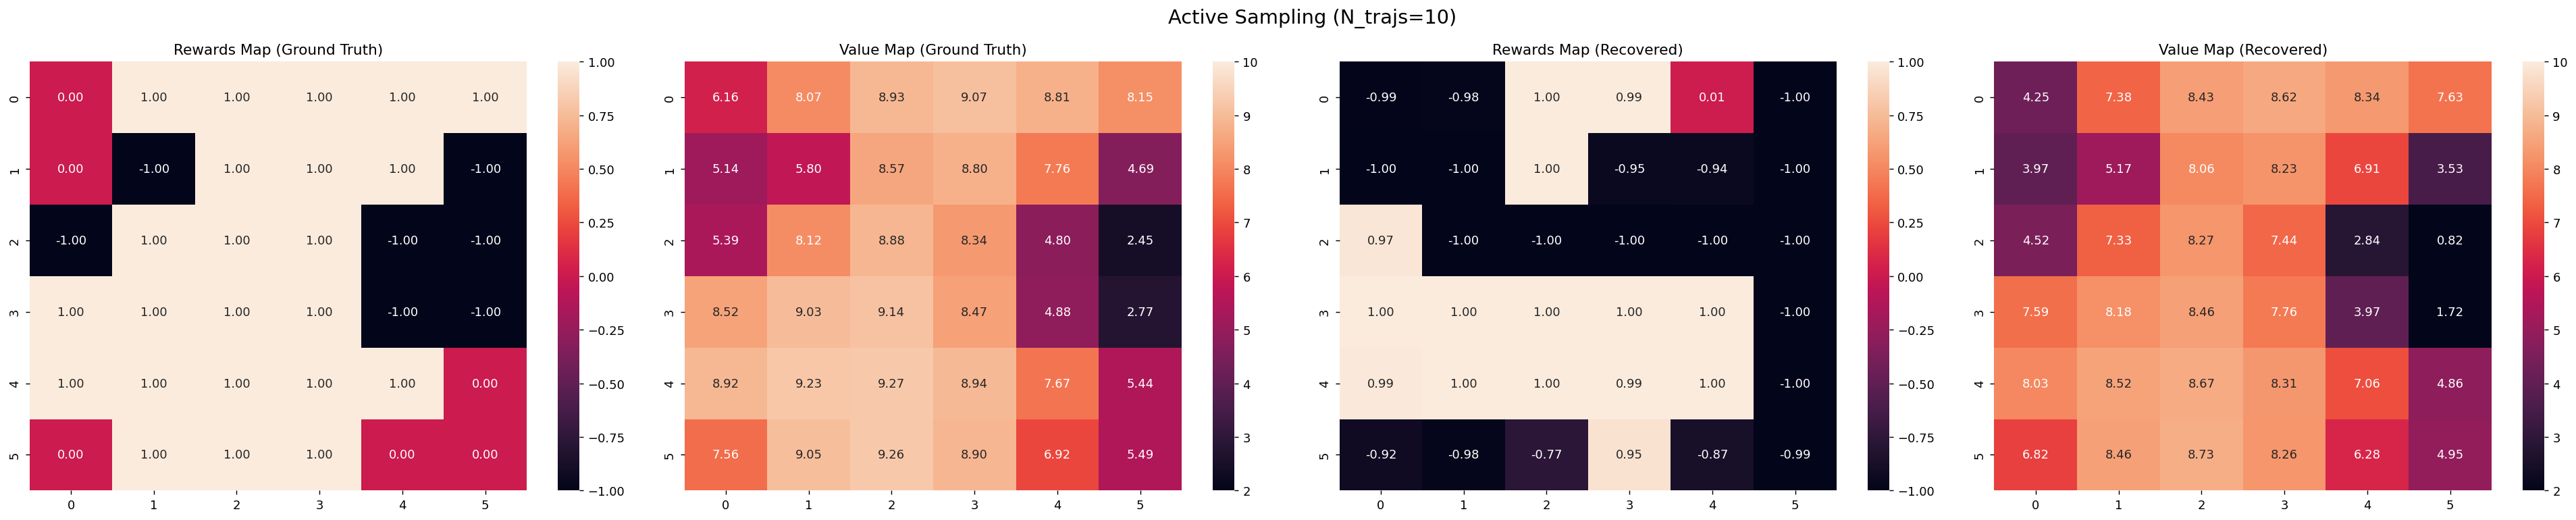

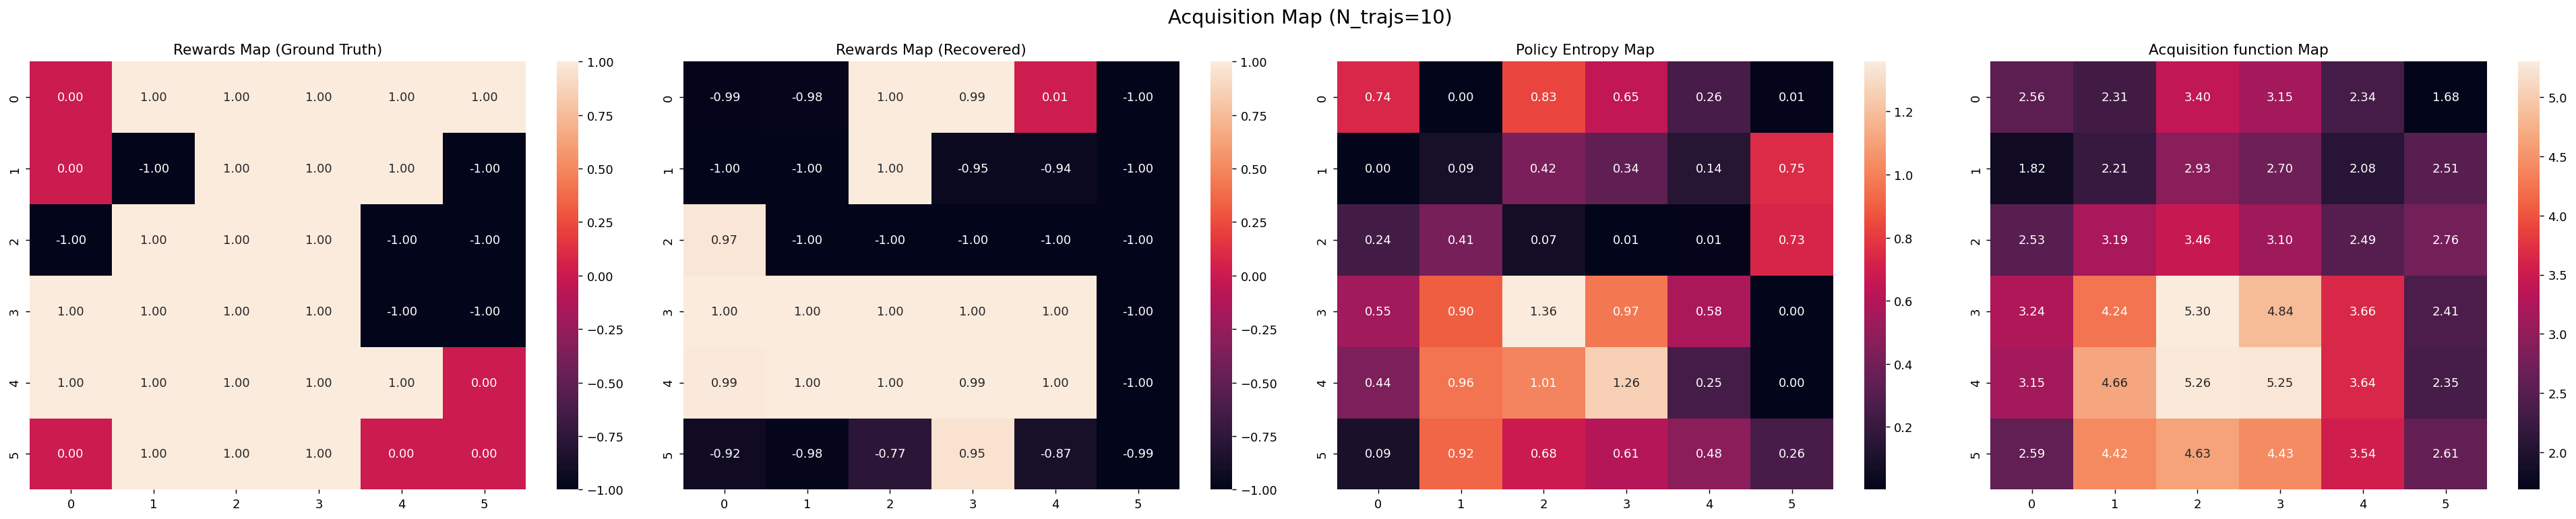

In [17]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(30, 6), dpi=130)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)

In [ ]:
visualizer.objectworld_reward_policy(search_idx=n_trajs)